In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns

In [2]:
df_1 = pd.read_csv('banknifty.csv')

## Preprocessing Data

In [3]:
def Date_Time(dataFrame):
    dateTime = dataFrame['date'].map(str)+dataFrame['time']
    k = pd.to_datetime(dateTime, format='%Y%m%d%H:%M')
    dataFrame['DateTime'] = k
    
    dataFrame['Day'] = dataFrame['DateTime'].dt.day
    dataFrame['Month'] = dataFrame['DateTime'].dt.month
    dataFrame['Year'] = dataFrame['DateTime'].dt.year
    #dataFrame['Hour'] = dataFrame['DateTime'].dt.hour
    #dataFrame['Minute'] = dataFrame['DateTime'].dt.minute
    
    dataFrame = dataFrame.drop(labels=['DateTime'], axis=1)
    dataFrame['group']= dataFrame['Year'].map(str) + dataFrame['Month'].map(str)+ dataFrame['Day'].map(str)

    dataFrame = dataFrame[['open', 'high', 'low', 'Day', 'Month', 'Year','group','close']]
    
    dataFrame= dataFrame.sort_values(by=['Year','Month','Day'])
    dataFrame= dataFrame.reset_index(drop=True)
    
    return(dataFrame)

In [4]:
def processing(dataframe):
    df = dataframe
    
    day_group = df['group'].unique() # extract unique hour values to form group based on days, month and year
    d_group_index = np.arange(1,len(day_group)+1)# for reindexing hour group values from 1 to number of groups.
    #As indexing starts from 0 so 1 is added
    
    # replacing hour group values with new indexing for extracting hour groups
    #(This step will take 20 minutes due to 3 hundred thousand samples)
    # it is already done once and results are saved in file hour.npy
    # so instead of running again, load this file

    for i in range(len(day_group)):
        df['group'] = df['group'].replace([day_group[i]],d_group_index[i])
    
    
    df1 = pd.DataFrame(df, index= day_group) # this data frame has day group as index values for extracting its index
     
    count_index = df['close'].groupby(df['group']).count() # counting each day group values
    
    day_index = []  # extracting months index
    w=0
    for i in count_index:
        w = i+w
        day_index.append(w)
    day_index = np.array(day_index) -1 
    # above steps are adding count values(in other words "commulative count_index") 
    # we need commulative count_index as count_index are absolute values from which required values cant be extracted
    
    # extracting close values which is last value of each month group
    close = []
    for i in day_index:
        t = df.loc[i,'close']
        close.append(t)
    close = np.array(close)
    
    #extracting low, high, month, year values of each month group
    low = pd.DataFrame(df['low'].groupby(df['group']).min()).reset_index(drop=True)
    high = pd.DataFrame(df['high'].groupby(df['group']).max()).reset_index(drop=True)
    Day = pd.DataFrame(df['Day'].groupby(df['group']).max()).reset_index(drop=True)
    Month = pd.DataFrame(df['Month'].groupby(df['group']).max()).reset_index(drop=True)
    Year = pd.DataFrame(df['Year'].groupby(df['group']).max()).reset_index(drop=True)
    
    #extracting first value of open from each month group
    openn = []
    for i in (day_index-count_index+1):
        r = df.loc[i,'open']
        openn.append(r)
    openn = np.array(openn)
    
    #creating new data frame with extracted values 
    df2 = pd.DataFrame()
    
    df2['open'] = openn
    df2['high'] = high
    df2['low'] = low
    df2['Day'] = Day
    df2['Month'] = Month
    df2['Year'] = Year
    df2['close'] = close
    # rearranging data into ascending form
    df2 = df2.sort_values(by=['Year','Month','Day'])
    df2 = df2.reset_index(drop=True) # reset index
    
    return(df2)

In [5]:
def scaling(dataFrame):

    close = np.array(dataFrame['close']).reshape(-1,1)
    stock_df = dataFrame.drop(labels=['close'], axis = 1)
    
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(stock_df)
    scaled_df = scaler.transform(stock_df)
    
    scaler2 = MinMaxScaler(feature_range=(0,1))
    scaler2.fit(close)
    scaled_close = scaler2.transform(close)
    
    scaled_df = pd.DataFrame(scaled_df, columns=stock_df.columns)
    scaled_df['close'] = scaled_close
    
    return(scaled_df, scaler, scaler2)

In [6]:
stock_df1 = Date_Time(df_1)

In [7]:
stock_df1.head()

,open,high,low,Day,Month,Year,group,close
0,11276.55,11276.55,11265.80,1,11,2012,2012111,11268.90
1,11267.95,11267.95,11258.85,1,11,2012,2012111,11260.05
2,11259.45,11259.45,11243.90,1,11,2012,2012111,11243.90
3,11246.50,11246.60,11237.90,1,11,2012,2012111,11238.90
4,11241.15,11247.20,11239.30,1,11,2012,2012111,11245.30


In [8]:
stock_df1_1 = processing(stock_df1)

In [9]:
stock_df1_1.head()

,open,high,low,Day,Month,Year,close
0,11276.55,11349.40,11230.20,1,11,2012,11306.25
1,11442.85,11477.55,11394.15,2,11,2012,11465.05
2,11442.20,11489.30,11401.30,5,11,2012,11475.20
3,11439.45,11568.45,11429.05,6,11,2012,11560.05
4,11548.50,11719.10,11519.60,7,11,2012,11658.70


In [11]:
stock_df2, in_scaler, out_scaler = scaling(stock_df1_1)

In [12]:
stock_df2.head()

,open,high,low,Day,Month,Year,close
0,0.217714,0.205992,0.517896,0.000000,0.909091,0.0,0.225087
1,0.231690,0.216638,0.526538,0.033333,0.909091,0.0,0.238453
2,0.231636,0.217614,0.526914,0.133333,0.909091,0.0,0.239307
3,0.231404,0.224189,0.528377,0.166667,0.909091,0.0,0.246449
4,0.240569,0.236703,0.533150,0.200000,0.909091,0.0,0.254752


## Data Plots

#### Time Series Distribution For Month

Text(0, 0.5, 'Stock Rate')

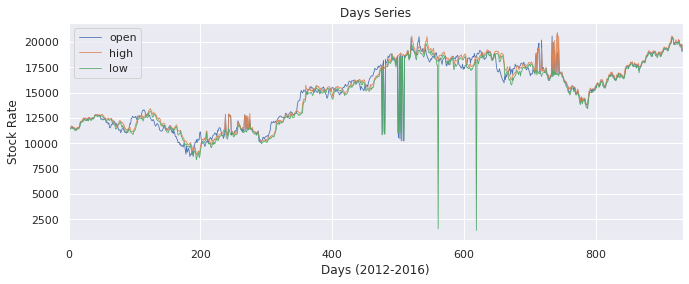

In [13]:
sns.set(rc={'figure.figsize':(11,4)})
stock_df1_1[['open','high','low']].plot(linewidth=0.8, title='Days Series')
plt.xlabel('Days (2012-2016)')
plt.ylabel('Stock Rate')

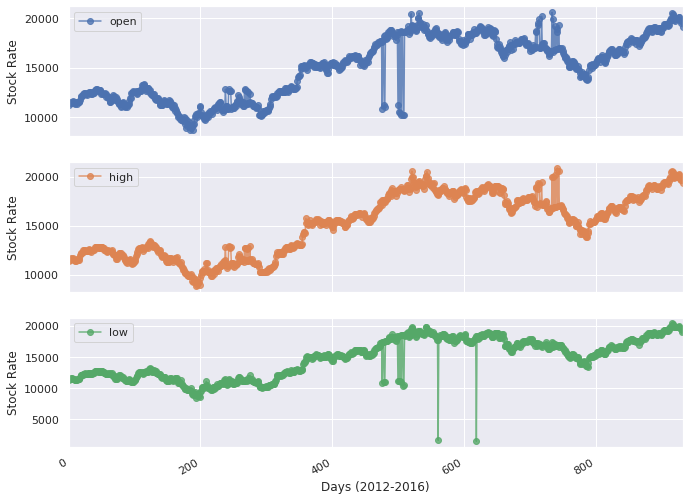

In [14]:
cols_plot = ['open', 'high','low']
axes = stock_df1_1[cols_plot].plot(marker='o', alpha=0.8, linestyle='-', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Stock Rate')
    ax.set_xlabel('Days (2012-2016)')

#### Box Pots

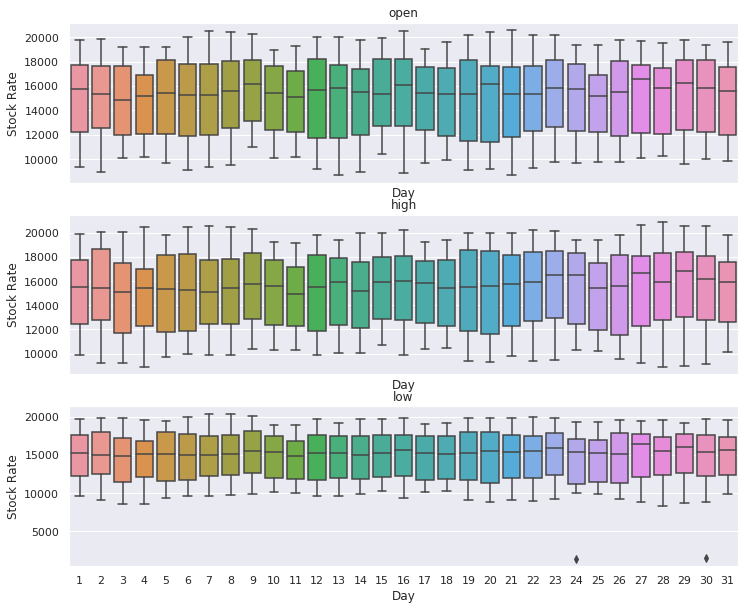

In [15]:
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
for name, ax in zip(['open', 'high', 'low'], axes):
    sns.boxplot(data=stock_df1_1, x='Day', y=name, ax=ax)
    ax.set_ylabel('Stock Rate')
    ax.set_title(name)

#### Heat Map

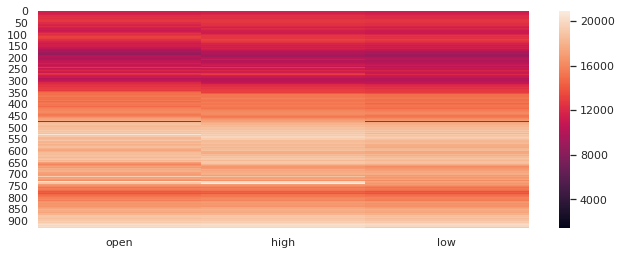

In [16]:
sns.heatmap(stock_df1_1[['open','high','low']])

#### Histograms and Curve Distribution

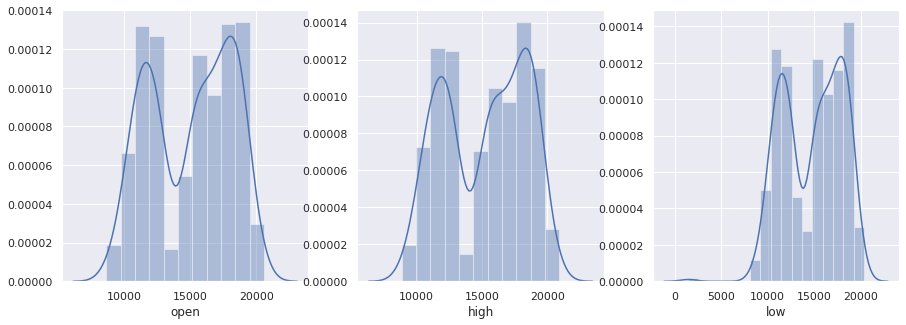

In [17]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
for name, ax in zip(['open', 'high', 'low'], axes):
    sns.distplot(stock_df1_1[name], ax=ax)

#### Correlation

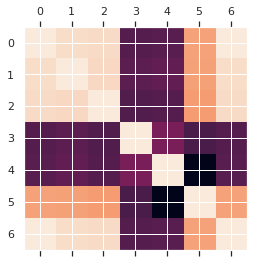

In [18]:
plt.matshow(stock_df1_1.corr())
plt.show()

#### Scatter Plot

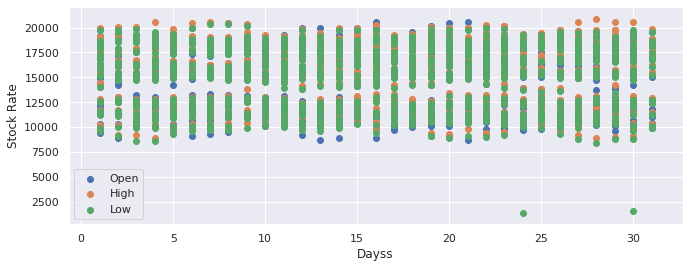

In [19]:
plt.scatter(stock_df1_1['Day'],stock_df1_1['open'])
plt.scatter(stock_df1_1['Day'],stock_df1_1['high'])
plt.scatter(stock_df1_1['Day'],stock_df1_1['low'])
plt.legend(['Open','High','Low'])
plt.xlabel('Dayss')
plt.ylabel('Stock Rate')
plt.show()

#### Trend Line

Text(0.5, 0, 'Days')

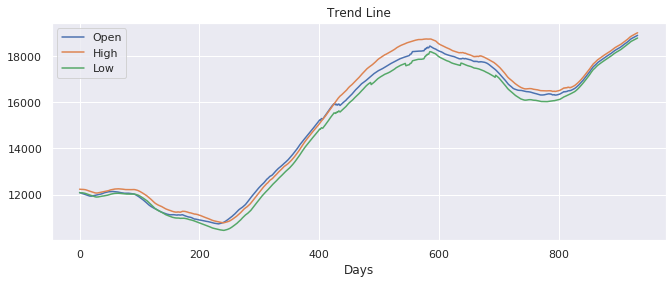

In [20]:
plt.plot(stock_df1_1['open'].rolling(window=150, center=True, min_periods=30).mean())
plt.plot(stock_df1_1['high'].rolling(window=150, center=True, min_periods=30).mean())
plt.plot(stock_df1_1['low'].rolling(window=150, center=True, min_periods=30).mean())
plt.legend(['Open','High','Low'])
plt.title('Trend Line')
plt.xlabel('Days')

## Splitting Data into Train/Test

In [21]:
def train_test_data(data):
    x = np.array(data.iloc[:,:-1])
    y = np.array(data.iloc[:,-1])
    
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, shuffle= True)
    
    return (x_train, x_test, y_train, y_test)

In [22]:
x_train_df1, x_test_df1, y_train_df1, y_test_df1 = train_test_data(stock_df2)

In [23]:
x_train_df1.shape

(746, 6)

In [24]:
y_train_df1.shape

(746,)

In [25]:
X_train_df1 = x_train_df1.reshape((x_train_df1.shape[0],1, x_train_df1.shape[1]))
X_test_df1 = x_test_df1.reshape((x_test_df1.shape[0],1, x_test_df1.shape[1]))

# LSTM

In [26]:
from keras.layers import LSTM
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation

Using TensorFlow backend.


In [27]:
lstm = Sequential()
lstm.add(LSTM(20, input_shape=(X_train_df1.shape[1], X_train_df1.shape[2])))
lstm.add(Dense(2, activation='sigmoid'))
lstm.add(Dense(y_train_df1.reshape(-1,1).shape[1]))

lstm.compile(loss='mae', optimizer='adam', metrics=['mean_squared_error'])

In [28]:
lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20)                2160      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 42        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 2,205
Trainable params: 2,205
Non-trainable params: 0
_________________________________________________________________


In [29]:
lstm.fit(X_train_df1, y_train_df1, epochs =20, verbose=1, batch_size=8,
          validation_data=(X_test_df1,y_test_df1), shuffle=True)

Train on 746 samples, validate on 187 samples
Epoch 1/20
746/746 [==============================] - 2s 3ms/step - loss: 0.7355 - mean_squared_error: 0.6163 - val_loss: 0.4657 - val_mean_squared_error: 0.2623
Epoch 2/20
746/746 [==============================] - 1s 1ms/step - loss: 0.2547 - mean_squared_error: 0.0988 - val_loss: 0.1521 - val_mean_squared_error: 0.0310
Epoch 3/20
746/746 [==============================] - 1s 1ms/step - loss: 0.1355 - mean_squared_error: 0.0266 - val_loss: 0.1269 - val_mean_squared_error: 0.0225
Epoch 4/20
746/746 [==============================] - 1s 1ms/step - loss: 0.1080 - mean_squared_error: 0.0176 - val_loss: 0.0920 - val_mean_squared_error: 0.0124
Epoch 5/20
746/746 [==============================] - 1s 1ms/step - loss: 0.0712 - mean_squared_error: 0.0087 - val_loss: 0.0568 - val_mean_squared_error: 0.0054
Epoch 6/20
746/746 [==============================] - 1s 1ms/step - loss: 0.0539 - mean_squared_error: 0.0053 - val_loss: 0.0483 - val_mean_squa

In [30]:
predict = lstm.predict(X_test_df1)

In [31]:
# Output value is scaled. To get actual value undo scaled value of output
print('Scaled Value Predicted: %.2f' %predict[2])
print('Actual Predicted Value: %.2f'%out_scaler.inverse_transform([predict[2]]))
print('True Value: %.2f' %out_scaler.inverse_transform([[y_test_df1[2]]]))

Scaled Value Predicted: 0.84
Actual Predicted Value: 18599.74
True Value: 17778.95


In [24]:
lstm.save('lstm.h5')

### Evaluation

In [32]:
print('R_2 Score: %.7f' %r2_score(y_test_df1, predict))
print('Mean Absolute Error: %.7f' %mean_absolute_error(y_test_df1, predict))
print('Mean Square Error: %.7f' %mean_squared_error(y_test_df1, predict))
print('Root Mean Square Error: %.7f' %np.sqrt(mean_squared_error(y_test_df1, predict)))

R_2 Score: 0.9921695
Mean Absolute Error: 0.0168982
Mean Square Error: 0.0005370
Root Mean Square Error: 0.0231740


### Plot

/home/kirmani/anaconda3/envs/env1/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':
/home/kirmani/anaconda3/envs/env1/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


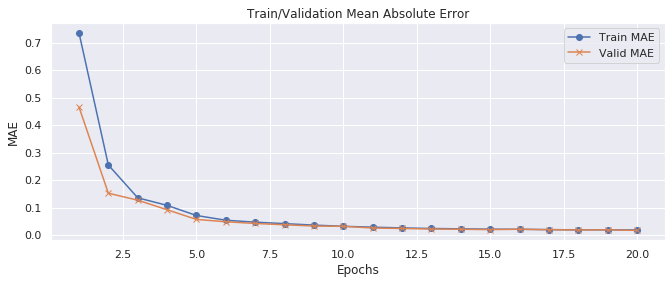

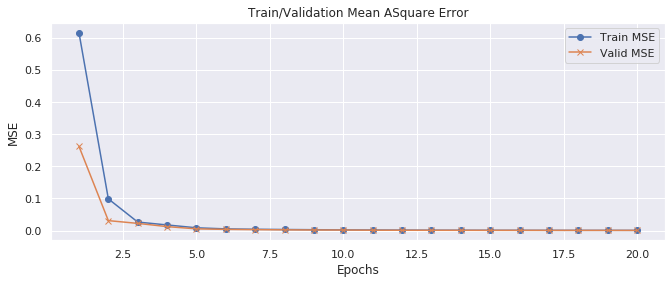

In [33]:
f, ax = plt.subplots()
ax.plot([None] + lstm.history.history['loss'], 'o-' )
ax.plot([None] + lstm.history.history['val_loss'], 'x-')

ax.legend(['Train MAE', 'Valid MAE'], loc=1)
ax.set_title('Train/Validation Mean Absolute Error')
ax.set_xlabel('Epochs')
ax.set_ylabel('MAE')
f.show()

f, ax = plt.subplots()
ax.plot([None] + lstm.history.history['mean_squared_error'], 'o-' )
ax.plot([None] + lstm.history.history['val_mean_squared_error'], 'x-')

ax.legend(['Train MSE', 'Valid MSE'], loc=1)
ax.set_title('Train/Validation Mean ASquare Error')
ax.set_xlabel('Epochs')
ax.set_ylabel('MSE')
f.show()

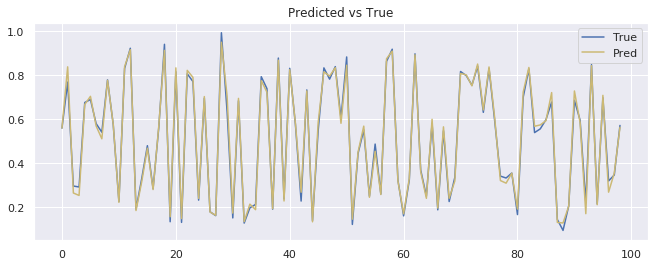

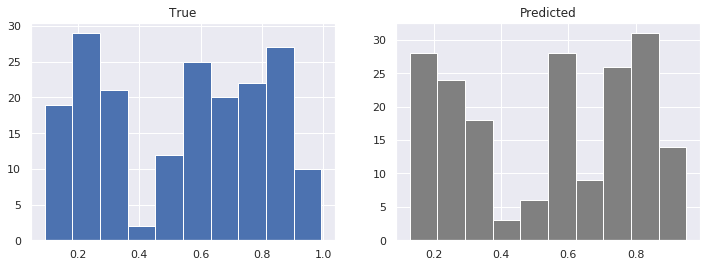

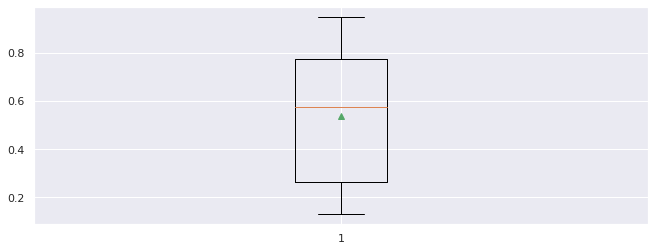

In [35]:
plt.plot(y_test_df1[1:100], 'b')
plt.plot( predict[1:100], 'y')
plt.legend(['True', 'Pred'])
plt.title('Predicted vs True')
plt.show()

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(y_test_df1)
plt.title('True')

plt.subplot(1,2,2)
plt.hist(predict, color='grey')
plt.title('Predicted')
plt.show()

plt.boxplot(predict, showmeans=True)
plt.show()

## User Input Data

In [38]:
def user():
    u = input('Do you want to enter custom data sample? Enter "y" or "n" :')
    if u == 'y':
        print('\nStock value range is 1400-21000')
        openn = float(input('Enter Opening Stock Value of the day: '))
        high = float(input('Enter Highest Stock Value of the day: '))
        low = float(input('Enter Lowest Stock Value of the day: '))
        date = str(input('Enter Date and time in format (21/03/201914:02) : '))
        
        new_data = np.array([[openn, high, low, date]])
    else:
        new_data = None
    
    
                       
    return new_data

In [39]:
def u_output(u_dt):
    user_df = pd.DataFrame(u_dt, columns=['Open','High', 'Low', 'Date'])
    user_dt = pd.to_datetime(user_df['Date'], format='%d/%m/%Y%H:%M')
    
    user_df2 = user_df.drop(labels=['Date'], axis=1)

    user_df2['Day'] = user_dt.dt.day
    user_df2['Month'] = user_dt.dt.month
    user_df2['Year'] = user_dt.dt.year
      
    sca_user_df1 = in_scaler.transform(user_df2)

    user_df1 = pd.DataFrame(sca_user_df1, columns=user_df2.columns)
    
    u_pred = lstm.predict(np.array(user_df1).reshape(user_df1.shape[0],1,user_df1.shape[1]))
    u_real1 = out_scaler.inverse_transform(u_pred) 
    
    return(u_real1)

In [41]:
user_data = user()

Do you want to enter custom data sample? Enter "y" or "n" :y

Stock value range is 1400-21000
Enter Opening Stock Value of the day: 3000
Enter Highest Stock Value of the day: 5049
Enter Lowest Stock Value of the day: 2050
Enter Date and time in format (21/03/201914:02) : 22/02/201415:07


In [42]:
if user_data is None:
    print('Process Completed')
else:
    o1 = u_output(user_data)
    print('Stock Closing is at: %.2f'%o1)

Stock Closing is at: 8544.67
